In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import r2_score
import sys

sys.path.append('..')
from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from parameter_choosing import *
from performance_metrics import *

# Load Data

In [6]:
def set_smallest_eigenvalue_real_part(A,lam):

    #lam is the desired maximum eigenvalue
    assert lam < 0, print('Eigenvalue must be negative')

    #get current eigenvalues
    e,v = np.linalg.eig(A)
    largest_eig = np.max(np.real(e))
    I = np.eye(len(e))
  
    #return scaled 
    return A - largest_eig*I + lam*I

def do_one_sde_run(n, lam_awake, lam_anesthesia, awake = 1):

    np.random.seed(42)

    A = np.random.normal(0,1/np.sqrt(n),(n,n))

    if awake == 1:
        #pick the stability parameter
        lam = lam_awake

        # Define the Weiner process    
        dW = np.sqrt(dt) * np.random.randn(N,n)

        #define systems matrix
        A_awake = set_smallest_eigenvalue_real_part(A,lam)

    else:

        lam = lam_anesthesia

        dW = np.sqrt(dt) * np.random.randn(N,n)

        A_anesthesia = set_smallest_eigenvalue_real_part(A,lam)


    # Define the function f(x)
    def f(x,lam):
        if awake == 1:
            return A_awake @ x
        else:
            return A_anesthesia @ x


    # Define the function g(x)
    def g(x):
        return 1

    # Initialize the x array
    x = np.zeros((N,n))
    x[0] = np.zeros(n)

    # Simulate the stochastic differential equation
    for i in range(1, N):
        x[i] = x[i-1] + f(x[i-1],lam) * dt + g(x[i-1]) * dW[i]

    return x

In [18]:
# Define the parameters
# N = int(1e5)
N = 20000
n = 100
T = 40.0
dt = T / N
x0 = 0.0

In [19]:
# #try two different lambdas
# lam_1, lam_2 = -1e0, -1e-2
# x_1 = do_one_sde_run(n, lam_awake = lam_1, lam_anesthesia = lam_2, awake = 1)
# x_2 = do_one_sde_run(n, lam_awake = lam_1, lam_anesthesia = lam_2, awake = 0)

# # Plot the results
# plt.plot(np.linspace(0, T, N), x_1[:,0], label = f'$\lambda_1(A) = {lam_1}$')
# plt.plot(np.linspace(0, T, N), x_2[:,0], label = f'$\lambda_1(A) = {lam_2}$')

# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('x[0]')
# plt.title('Noisy Linear Filter $\dot{x} = Ax + w(t)$')

# plt.show()

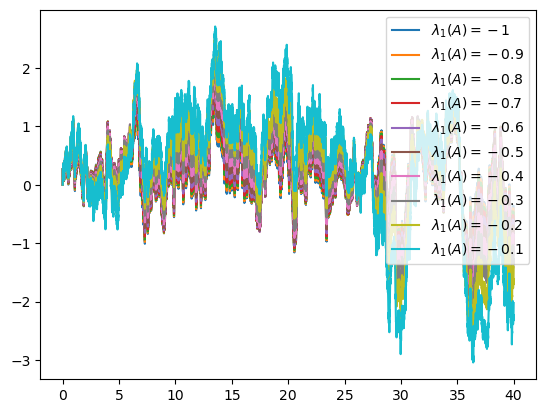

In [20]:
lams = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1]
trajs = {}
for lam in lams:
    x_1 = do_one_sde_run(n, lam_awake = lam, lam_anesthesia = lam_2, awake = 1)
    trajs[lam] = x_1
    plt.plot(np.linspace(0, T, N), x_1[:,0], label = f'$\lambda_1(A) = {lam}$')
plt.legend()
plt.show()

# Parameter Picking

In [26]:
num_samples = 10
indices = np.random.choice(np.arange(n), num_samples, replace=False)

In [27]:
parameter_grid = ParameterGrid(
    window_vals=np.array([5000]),
    matrix_size_vals=np.array([500]),
#     explained_variance_vals=np.array([0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 0.97, 0.99, 0.995, 0.999, 0.9999]),
#     r_vals=np.array([100, 200, 500, 750, 1000, 1500, 2000, 2500, 3000]),
    r_vals=np.array([10, 25, 50, 75, 100, 200, 300, 400, 500]),
    lamb_vals=np.array([0, 1e-12, 1e-8, 1e-3, 1e-2, 1e-1, 0.5]),
    reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
#     reseed_vals=np.array([1, 5, 10, 15])
)

In [28]:
prediction_time = 3000

In [29]:
results = {}
transient = 2000
for key, signal in trajs.items():
    print("-"*50)
    print(f"lamb = {key}")
    print("-"*50)

    window = parameter_grid.window_vals[0]

#     signal = (signal - signal.mean())/signal.std()

    train_signal = signal[transient:transient + window, indices]
    test_signal = signal[transient + window:transient + window + prediction_time, indices]

    results[key] = parameter_search(train_signal, test_signal, parameter_grid, dt=dt, verbose=True, use_torch=True, device='cuda')

--------------------------------------------------
lamb = -1
--------------------------------------------------


  0%|          | 0/1071 [00:00<?, ?it/s]

--------------------------------------------------
lamb = -0.9
--------------------------------------------------


  0%|          | 0/1071 [00:00<?, ?it/s]

--------------------------------------------------
lamb = -0.8
--------------------------------------------------


  0%|          | 0/1071 [00:00<?, ?it/s]

--------------------------------------------------
lamb = -0.7
--------------------------------------------------


  0%|          | 0/1071 [00:00<?, ?it/s]

--------------------------------------------------
lamb = -0.6
--------------------------------------------------


  0%|          | 0/1071 [00:00<?, ?it/s]

--------------------------------------------------
lamb = -0.5
--------------------------------------------------


  0%|          | 0/1071 [00:00<?, ?it/s]

--------------------------------------------------
lamb = -0.4
--------------------------------------------------


  0%|          | 0/1071 [00:00<?, ?it/s]

--------------------------------------------------
lamb = -0.3
--------------------------------------------------


  0%|          | 0/1071 [00:00<?, ?it/s]

--------------------------------------------------
lamb = -0.2
--------------------------------------------------


  0%|          | 0/1071 [00:00<?, ?it/s]

--------------------------------------------------
lamb = -0.1
--------------------------------------------------


  0%|          | 0/1071 [00:00<?, ?it/s]

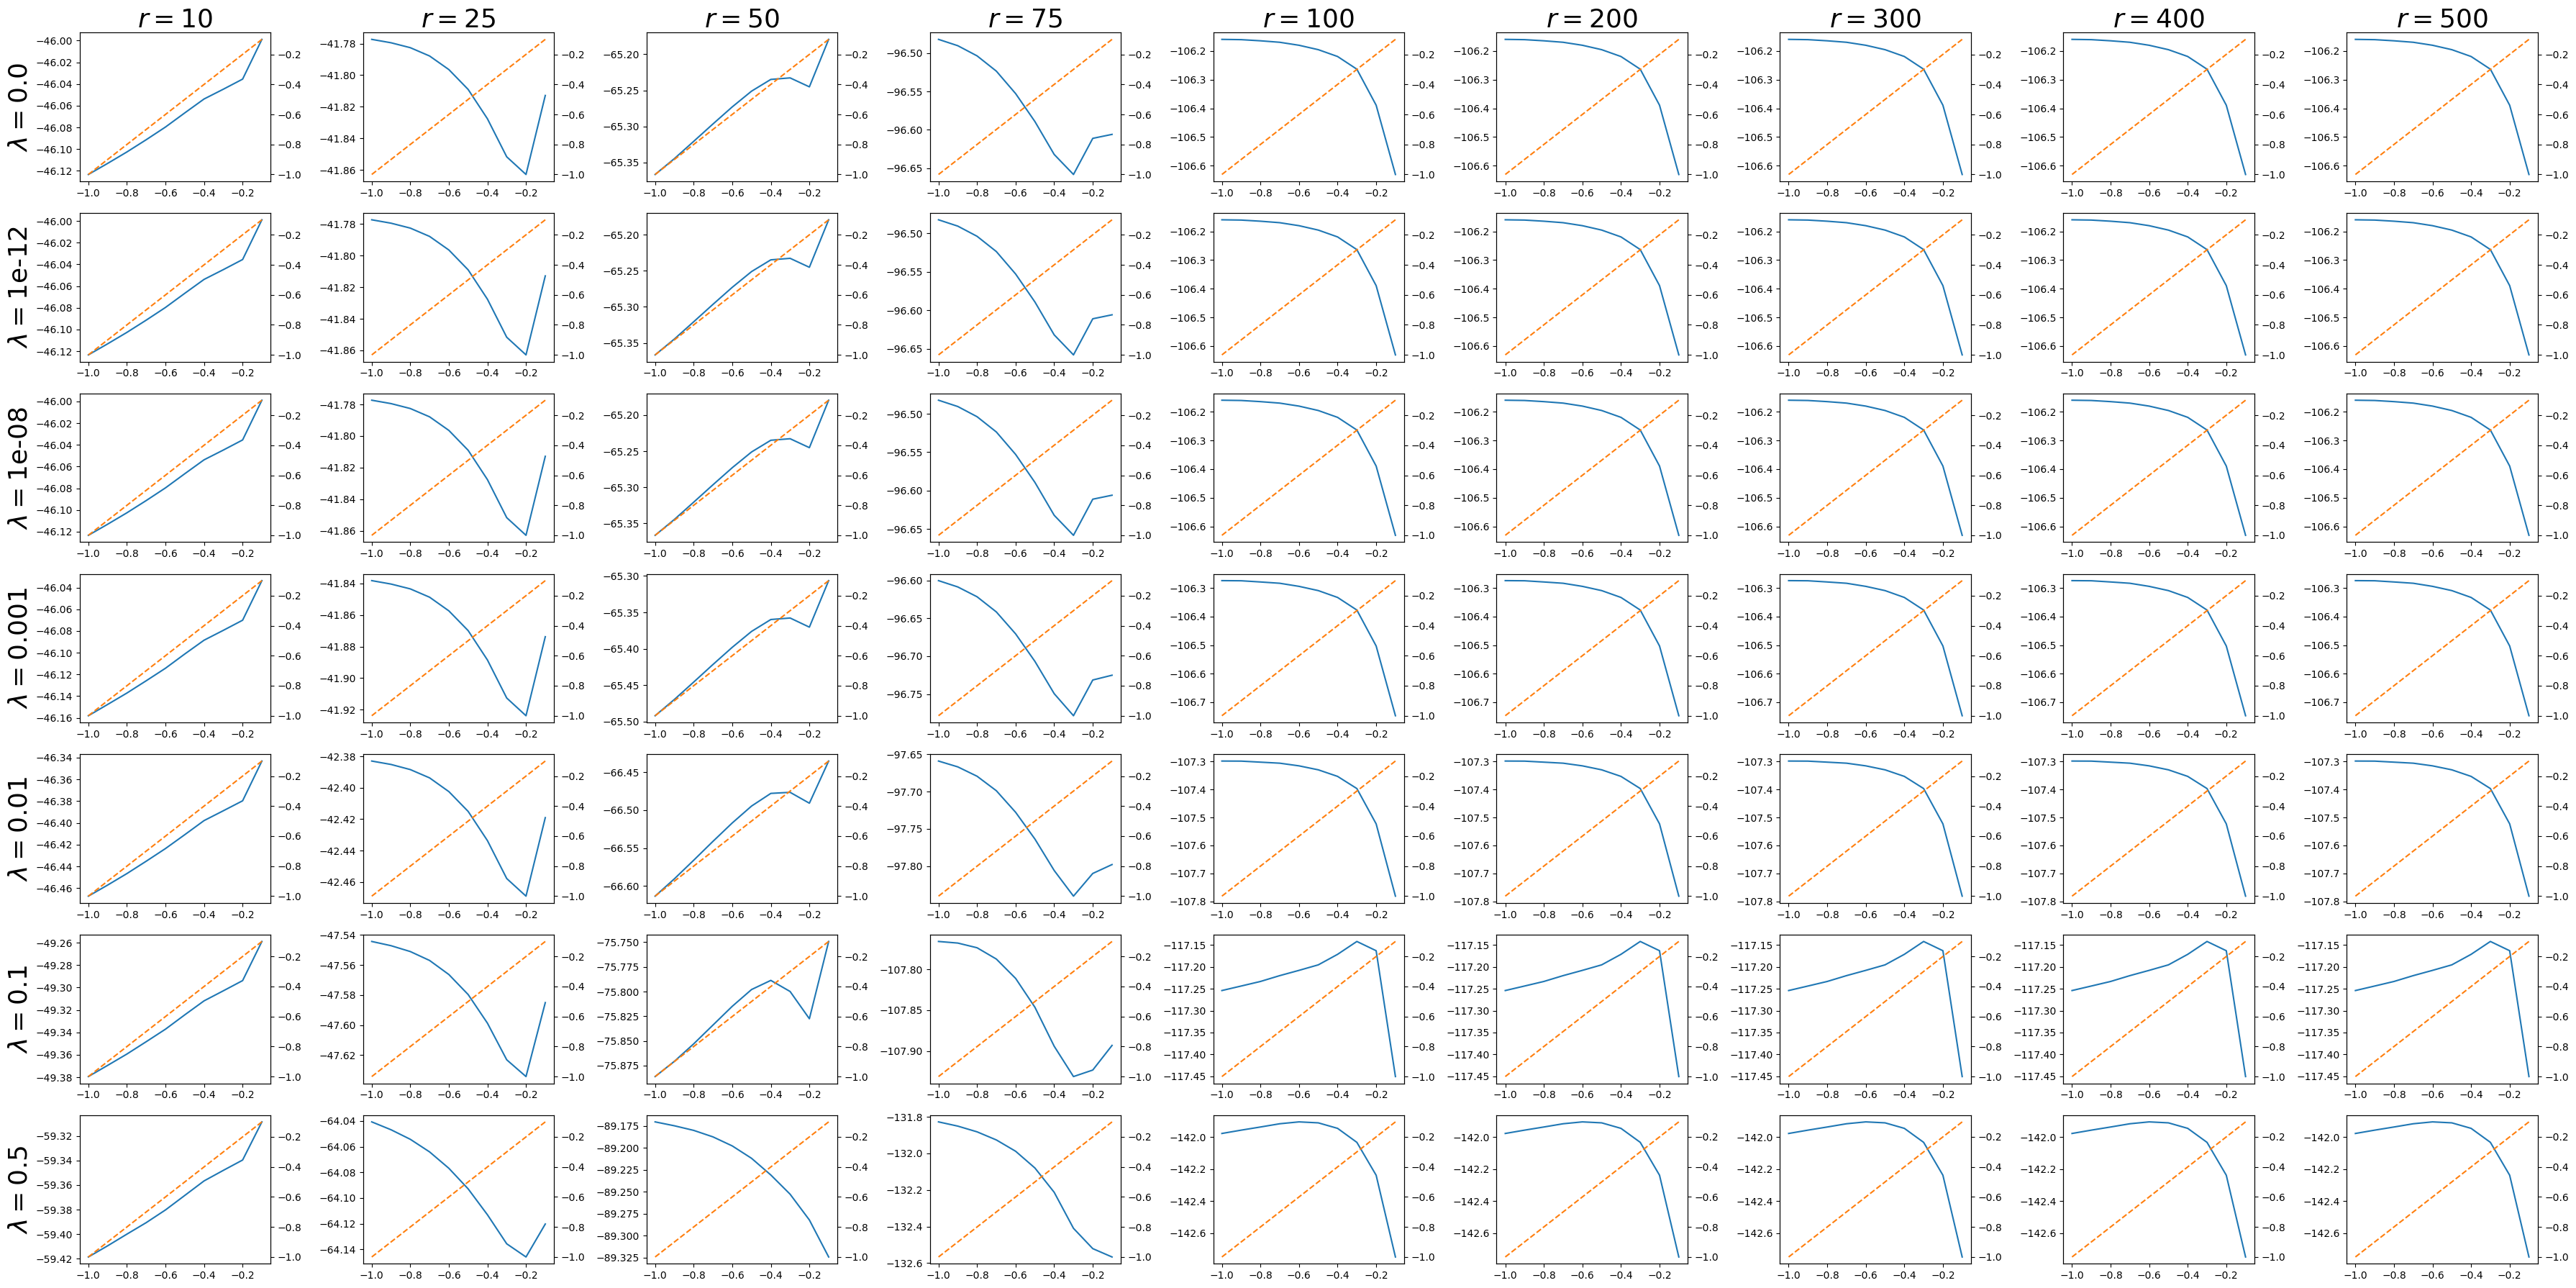

In [76]:
keys = lams
top_percent = 0.3
r_vals = results[keys[0]].r.unique()
lamb_vals = results[keys[0]].lamb.unique()

fig, axs = plt.subplots(len(lamb_vals), len(r_vals), figsize=(36, 18))
for i, r in enumerate(r_vals):
    for j, lamb in enumerate(lamb_vals):
        curve = np.array([results[key][np.logical_and(results[key].r == r, results[key].lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()).to_numpy()[0] for key in keys])
        se = np.array([results[key][np.logical_and(results[key].r == r, results[key].lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()/np.sqrt(int(top_percent*len(x)))).to_numpy()[0] for key in keys])
        ax = axs[j, i]
        ax.plot(keys, curve)
#         ax.fill_between(keys, curve-se, curve+se, color='C0', alpha=0.3)
        ax2 = ax.twinx()
        ax2.plot(keys, lams, linestyle='--', c='C1')
#         ax2.plot([lyaps[key][:int(len(lyaps[key])*top_percent)].mean() for key in keys], linestyle='--', c='C1')
        if i == 0:
            ax.set_ylabel(f"$\lambda = ${lamb}", fontsize=26)
        if j == 0:
            ax.set_title("$r = $" + f"{r}", fontsize=26)
plt.tight_layout()
plt.show()

In [35]:
explained_variance = {}
for key in tqdm(keys):
    delase = DeLASE(trajs[key][2000:7000], matrix_size=100, dt=dt, use_torch=True, device='cuda')
    explained_variance[key] = torch.cumsum(delase.S.cpu()**2/((delase.S.cpu()**2).sum()), 0)

  0%|          | 0/10 [00:00<?, ?it/s]

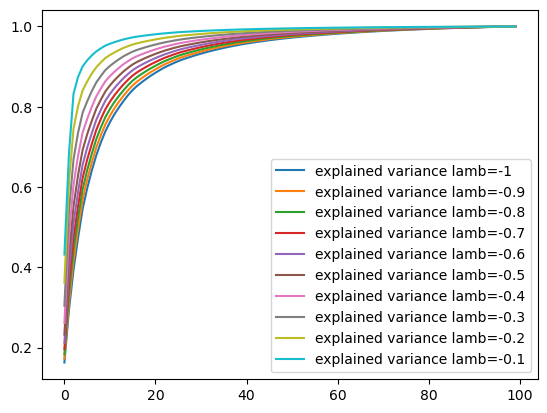

In [37]:
for key in keys:
    plt.plot(explained_variance[key], label=f'explained variance lamb={key}')
plt.legend()
plt.show()

In [71]:
thresh = 0.99
r = np.max([np.argmax(explained_variance[key] > thresh) for key in keys])

In [72]:
r

72

In [73]:
stability_params = {}
for key in tqdm(keys):
    delase = DeLASE(trajs[key][2000:7000], matrix_size=100, dt=dt, use_torch=True, device='cuda')
    delase.compute_havok_dmd(r=r, lamb=0)
    delase.compute_jacobians()
    delase.get_stability(max_freq=500, max_unstable_freq=125)
    stability_params[key] = delase.stability_params

  0%|          | 0/10 [00:00<?, ?it/s]

In [74]:
top_percent = 0.05

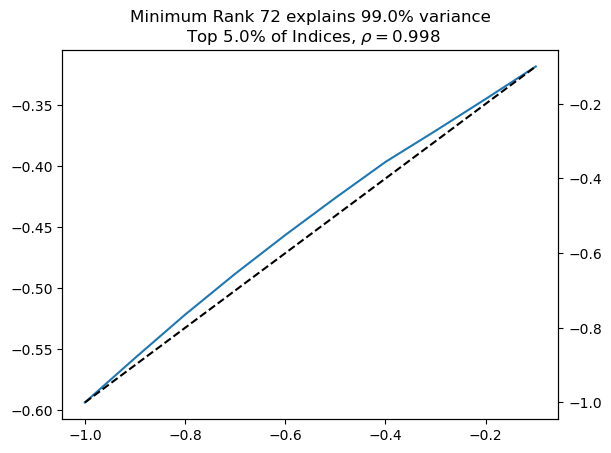

In [75]:
mean_stab = np.array([stability_params[key][:int(len(stability_params[key])*top_percent)].cpu().mean() for key in keys])
se_stab = np.array([stability_params[key][:int(len(stability_params[key])*top_percent)].cpu().std()/np.sqrt(int(len(stability_params[key])*top_percent)) for key in keys])
plt.plot(keys, mean_stab, label=f'mean top {top_percent}')
# plt.fill_between(keys, mean_stab - se_stab, mean_stab + se_stab, color='C0', alpha=0.3)
ax2 = plt.gca().twinx()
ax2.plot(keys, lams, c='k', linestyle='--', label='')
rho = scipy.stats.pearsonr(mean_stab, lams)[0]
plt.title(f'Minimum Rank {r} explains {thresh*100}% variance\n Top {top_percent*100}% of Indices, ' + r'$\rho = $' + f"{rho:.3f}")
plt.show()